In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 23c

##  Convolutional Neural Network (CNN)
- Fashion MNIST
- Dropout (after CNN Layer)
- Dataset From CSV File

<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

    
%matplotlib inline

2023-06-11 09:11:57.576420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 09:11:58.112114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'dropout_after_cnn'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 50 # number of cycles to run
BATCH_SIZE = 32 # inline of Traing Rows being 60000
PATIENCE = 5 # Patience for early stopping

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
print (physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-11 09:11:58.587575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 09:11:58.625423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 09:11:58.625608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Helper Function

In [5]:
def fn_verify_dir(_path : str):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder
        
        print(f'Found Directory: {_path}.') # advised the user
        
    else:
        
        os.makedirs(_path) # create the path
        
        print(f'Created folder : { _path}')

In [6]:
fn_verify_dir(inpDir) # check/create input dir
fn_verify_dir(outDir) # check/create output dir
fn_verify_dir(modelDir) # check/create model Dir
fn_verify_dir(os.path.join(modelDir,subDir)) # check/ create subdir for model

Found Directory: ../../input.
Found Directory: ../output.
Found Directory: ../models.
Found Directory: ../models/fashion_mnist.


In [7]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [8]:
def fn_plot_label(train_df : pd.DataFrame, test_df : pd.DataFrame):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title="Training distribution",
                                               color = 'DarkBlue', alpha = 0.8)


    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar',
                                              title="Testing distribution",
                                              color = 'Orange', alpha = 0.8)

## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [9]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [10]:
train_filename = os.path.join(inpDir, subDir, 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, subDir, 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [11]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


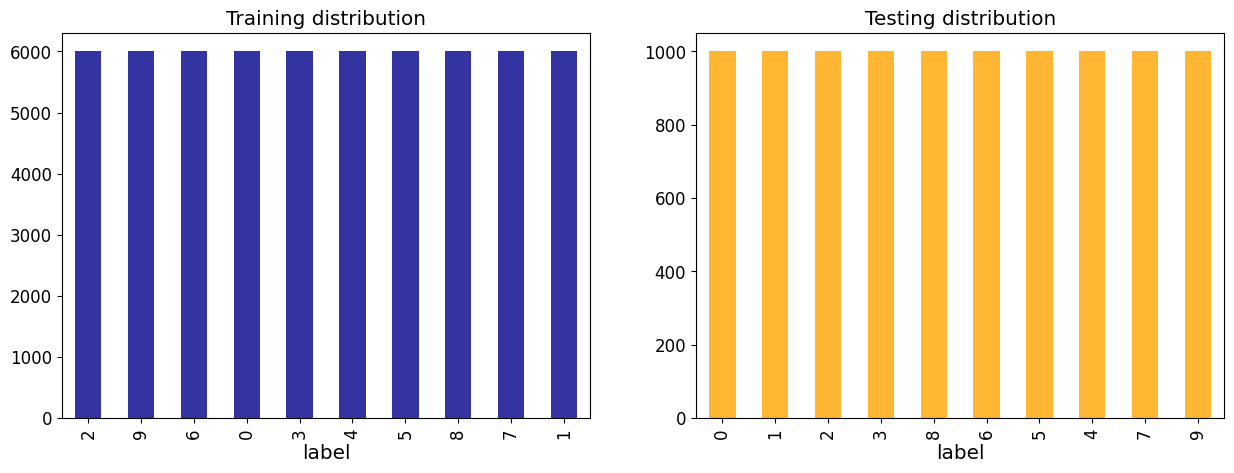

In [13]:
fn_plot_label(train_df, test_df)

## Converting to Datasets

In [14]:
# Each row need to be seperated in features and labels
def split_feature_label(row):

    '''
    Args:
        row: tensor of 785 values
    returns:
        feature : np.ndarray of shape (28 x 28, 1)
        label: integer
    '''
    
    feature = tf.reshape(row[1:], [28, 28, 1])
    
    label = row[0]
    
    return feature, label

In [15]:
# Create training dataset
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

2023-06-11 09:12:00.754590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 09:12:00.754768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 09:12:00.754880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


2023-06-11 09:12:01.795633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [60000,785]
	 [[{{node Placeholder/_0}}]]


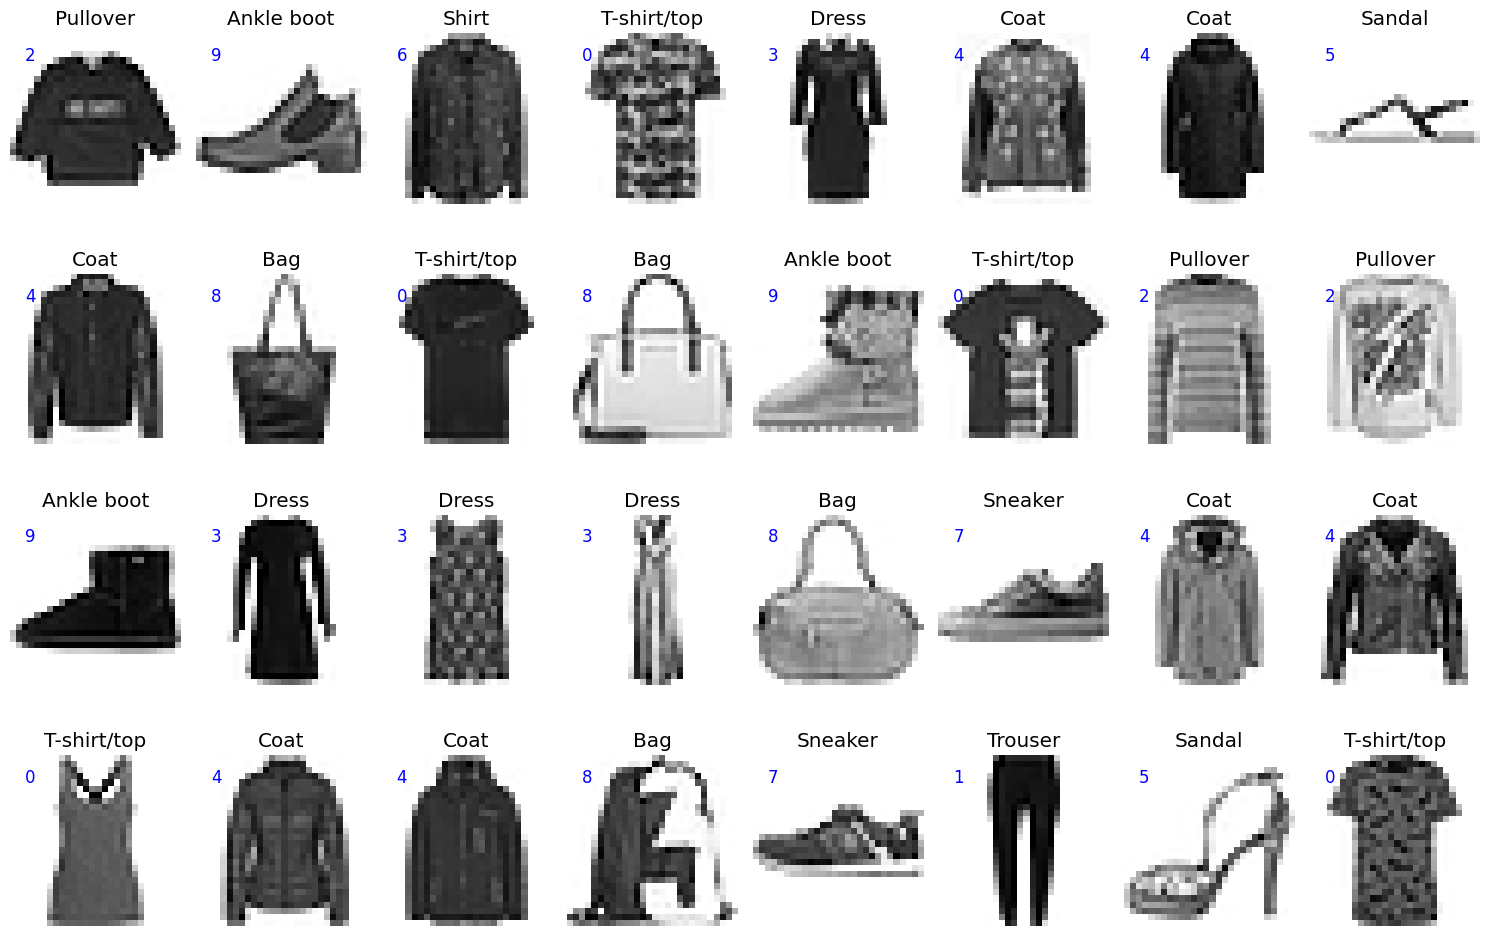

In [16]:
for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

2023-06-11 09:12:02.874798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [10000,785]
	 [[{{node Placeholder/_0}}]]


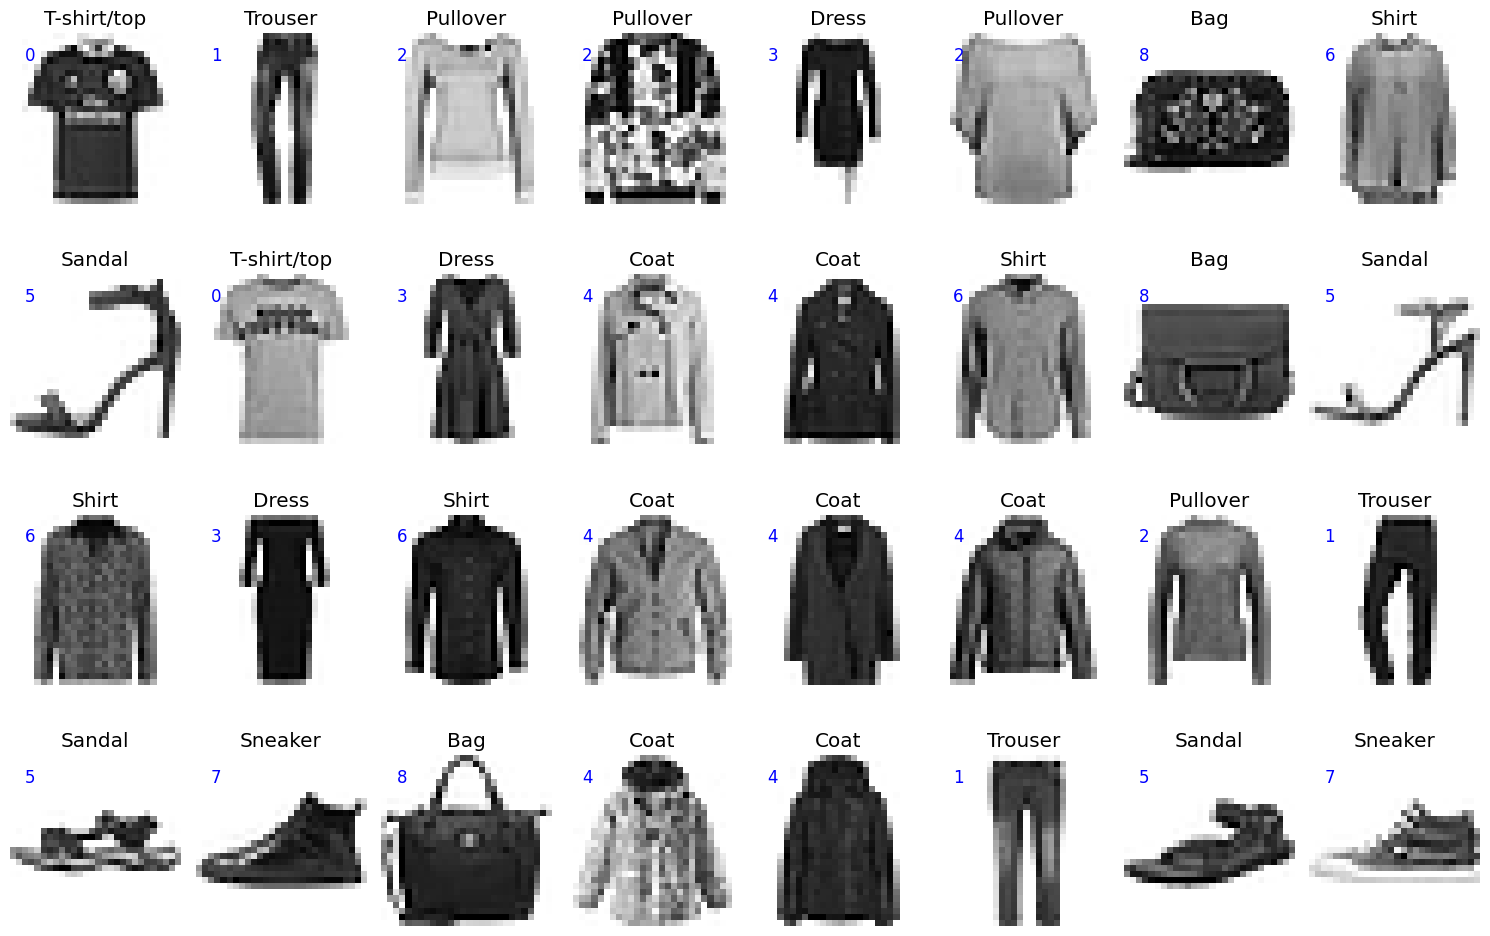

In [17]:
for images, labels in test_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [18]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Create the convolutional base

<img src = '../../images/dnn_nb_cnn_MNIST.png' style = 'width:800px;' alt="Demo Convolution Network MNIST" align="left">

In [19]:
## Model with Dropout

In [20]:
dor1 = 0.1 # drop out rates
dor2 = 0.2 # drop out rates
dor3 = 0.35 # drop out rates

# kernel (weight initialization)
krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

# create a sequential model
# supply layers as list or add
model = tf.keras.models.Sequential()

# rescale to values between [0, 1.0]
model.add(tf.keras.layers.Rescaling(1./255),)

#############
### Set 01 ##
#############
# Convolution 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), # number of filters and filter size
                                 kernel_initializer = krnl_init,
                                 padding='same', 
                                 activation='relu',
                                 input_shape=(28, 28, 1))) # (28 x 28 x 32)

# Dropout 1 - Drop out rate dor1
model.add(tf.keras.layers.Dropout(rate = dor1, 
                                  seed=RANDOM_STATE))

# Pool 1
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # (14 x 14 x 32)


#############
### Set 02 ##
#############

# Convolution 2
model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation='relu')) # (12 x 12 x 64)

# Dropout 2 - Drop out rate dor1
model.add(tf.keras.layers.Dropout(rate = dor1, 
                                  seed=RANDOM_STATE))

# Pool 2
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 6 x 6 x 64)



#############
### Set 03 ##
#############

# Convolution 3
model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 4 x 4 128)

# Dropout 3 - Drop out rate dor2
model.add(tf.keras.layers.Dropout(rate = dor3, 
                                  seed=RANDOM_STATE))

In [21]:
model.add(tf.keras.layers.Flatten())


# Dense 1
model.add(tf.keras.layers.Dense(64,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# Dropout 4
model.add(tf.keras.layers.Dropout(rate = dor3, seed=RANDOM_STATE))

# Dense 2
model.add(tf.keras.layers.Dense(10))

## Define Call backs

In [22]:
checkpoint_filepath = os.path.join(modelDir, subDir, altName)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    save_best_only = True,
    verbose = 1
)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline =None,
    restore_best_weights=True,
    verbose = 1)


### Compile and train the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),              
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=test_ds,epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks = [early_stopping_callback, model_checkpoint_callback])

Epoch 1/50


2023-06-11 09:12:04.217391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [60000,785]
	 [[{{node Placeholder/_0}}]]
2023-06-11 09:12:04.780586: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-11 09:12:06.177552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-06-11 09:12:07.979222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-11 09:12:07.994244: I tensorflow/compiler/xla/service/service.cc:169] XLA ser

1872/1875 [============================>.] - ETA: 0s - loss: 0.5429 - accuracy: 0.8053

2023-06-11 09:12:14.240358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [10000,785]
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.33275, saving model to ../models/fashion_mnist/dropout_after_cnn
1875/1875 [==============================] - 11s 3ms/step - loss: 0.5427 - accuracy: 0.8054 - val_loss: 0.3328 - val_accuracy: 0.8809
Epoch 2/50
1865/1875 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8730
Epoch 2: val_loss improved from 0.33275 to 0.27767, saving model to ../models/fashion_mnist/dropout_after_cnn
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3564 - accuracy: 0.8730 - val_loss: 0.2777 - val_accuracy: 0.8988
Epoch 3/50
1865/1875 [============================>.] - ETA: 0s - loss: 0.3056 - accuracy: 0.8898
Epoch 3: val_loss improved from 0.27767 to 0.26029, saving model to ../models/fashion_mnist/dropout_after_cnn
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3057 - accuracy: 0.8898 - val_loss: 0.2603 - val_accuracy: 0.9044
Epoch 4/50
1871/1875 [============================>.] - ETA: 0s - loss: 0.278

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                        

In [25]:
res_df = pd.DataFrame(history.history)
res_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.542650,0.805383,0.332754,0.8809
1,0.356394,0.873050,0.277670,0.8988
2,0.305686,0.889783,0.260292,0.9044
3,0.278064,0.900267,0.229491,0.9126
4,0.261434,0.906233,0.220957,0.9150


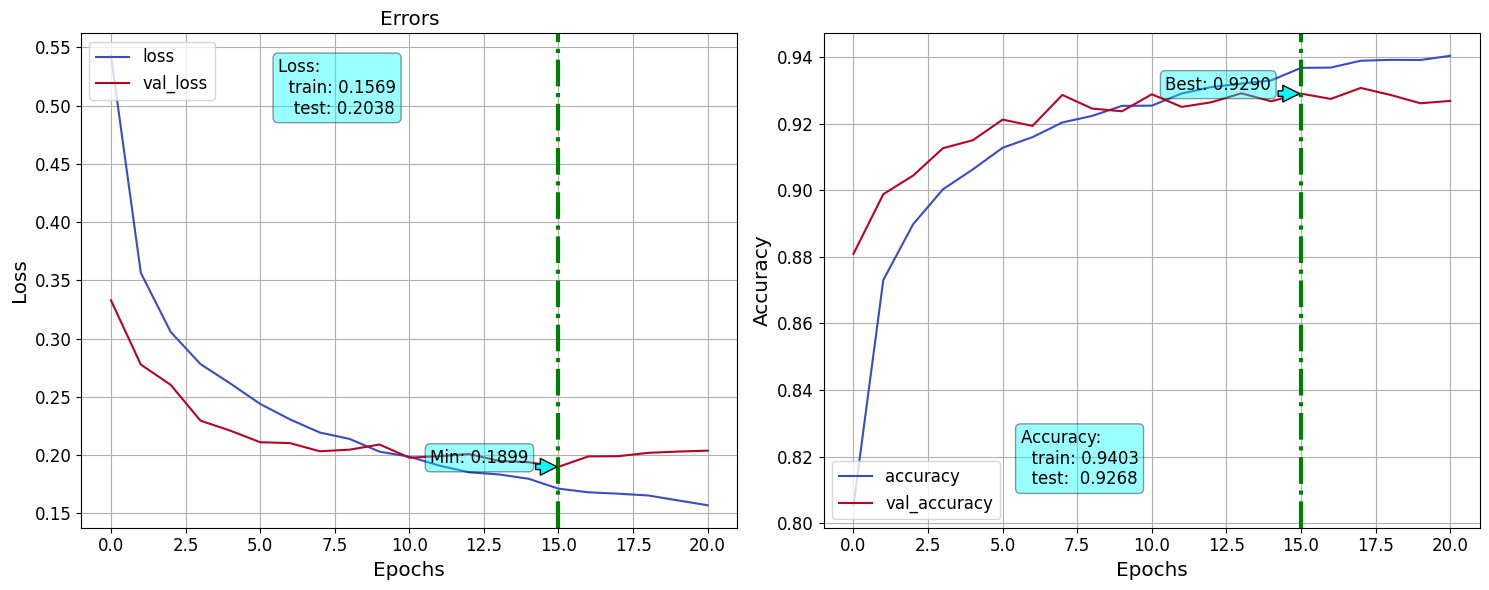

In [26]:
fn_plot_tf_hist(res_df) #0.1942, 0.9300

### Notes:
- Batch size is 32.
- Early stopping is used.
- Dropout is apploed after CNN and before Maxpool layer. Max pool is extracting most significant feature and droup out is supressing a few. So maxpool may eliminate nodes supressed by dropout. Please verify both models. 

### Evaluate the model

In [27]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

313/313 - 0s - loss: 0.1899 - accuracy: 0.9290 - 321ms/epoch - 1ms/step


In [28]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [29]:
yhat = model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

313/313 [==============================] - 0s 806us/step
Accuracy score on Test Data : 0.929


In [30]:
confusion_matrix(y_test, y_pred)

array([[919,   0,  14,  14,   1,   0,  51,   0,   1,   0],
       [  2, 994,   0,   3,   1,   0,   0,   0,   0,   0],
       [ 21,   0, 907,  16,  23,   0,  33,   0,   0,   0],
       [ 12,   5,   3, 953,  17,   0,  10,   0,   0,   0],
       [  1,   1,  40,  24, 902,   0,  31,   0,   1,   0],
       [  0,   0,   0,   0,   0, 976,   0,  16,   1,   7],
       [135,   1,  59,  26,  55,   0, 723,   0,   1,   0],
       [  0,   0,   0,   0,   0,   2,   0, 959,   0,  39],
       [  6,   0,   0,   2,   1,   0,   7,   2, 982,   0],
       [  0,   0,   0,   0,   0,   0,   0,  25,   0, 975]])

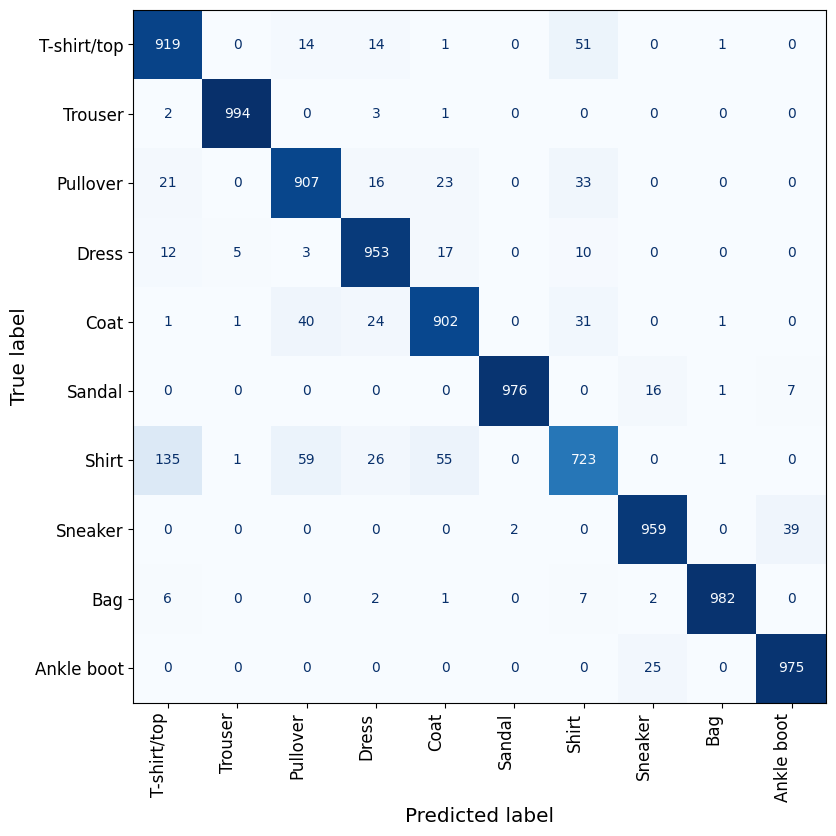

In [31]:
CMAP = plt.cm.Blues

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (9,9))

disp.plot(ax = ax, cmap=CMAP, colorbar=False);

ax.set_xticklabels(class_labels.values(),rotation=90, ha='right');

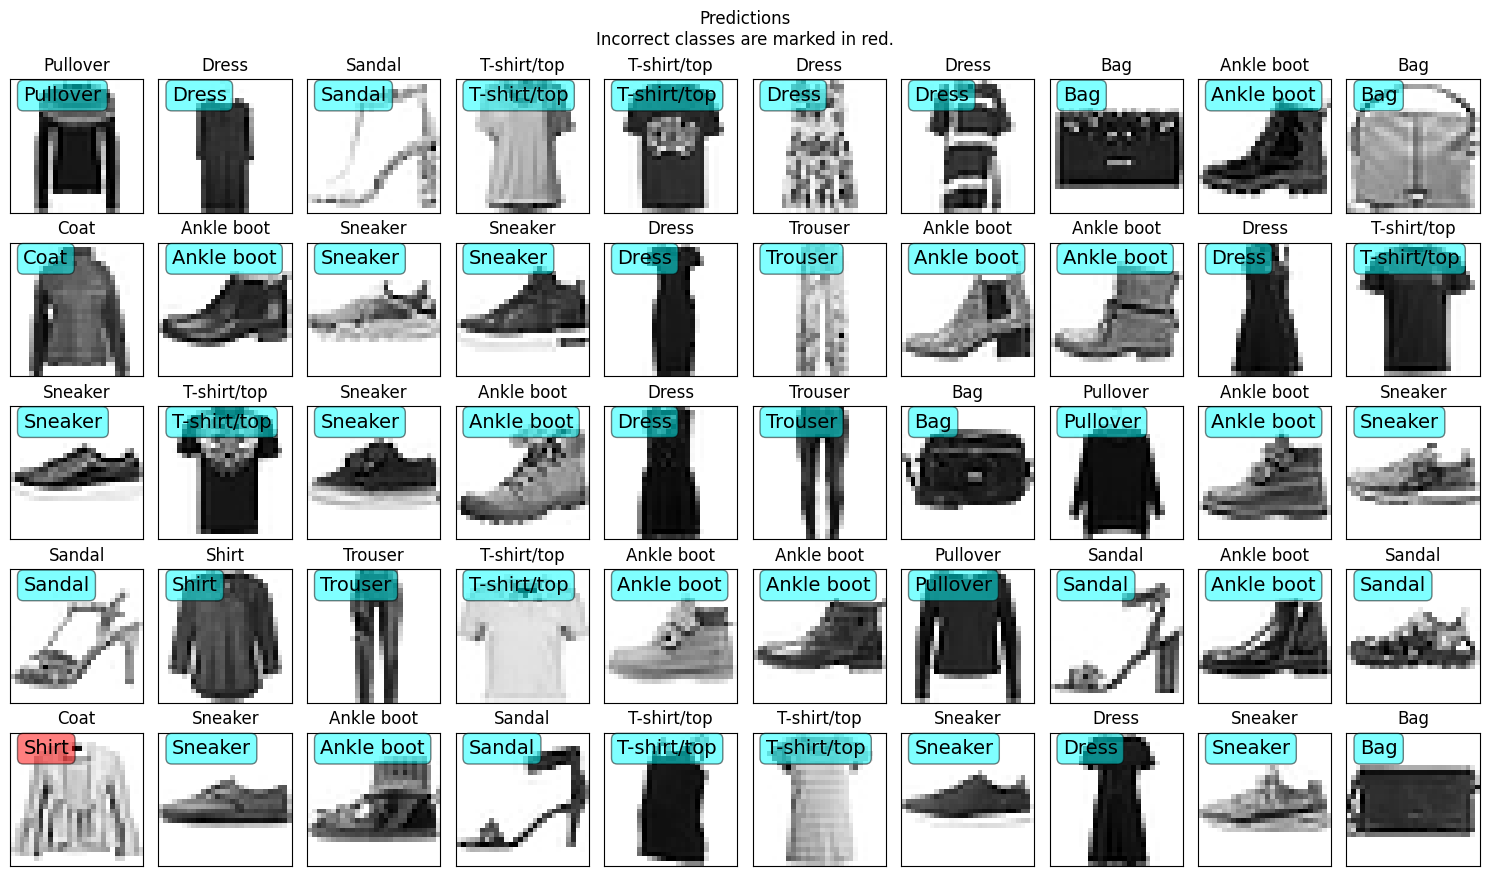

In [32]:
# Results plot

test_df['y_pred'] = y_pred

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

fntsize = 12

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row[0]!= row[-1]:
        color = 'red'
    else:
        color = 'cyan'
        
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_labels[row[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_labels[row[-1]], transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\nIncorrect classes are marked in red.')
plt.tight_layout()
plt.show()